In [1]:
import numpy as np
import sys
import os
import robosuite as suite
from robosuite.environments.manipulation.empty import Empty
from scipy import interpolate
from robosuite.utils.mjmod import DynamicsModder
import ikpy.chain
import xml.etree.ElementTree as ET
from scipy.spatial.transform import Rotation

In [2]:
horizon = 2000
num_cloth_joints = 9

In [3]:
suite.environments.base.register_env(Empty)
controller_config = suite.load_controller_config(default_controller="JOINT_POSITION")

In [4]:
env = suite.make(
    "Empty",
    robots="IIWA",             # load a Sawyer robot and a Panda robot
    gripper_types="ClothGripper",                # use default grippers per robot arm
    controller_configs=controller_config, 
    has_renderer=True,                      # on-screen rendering
    render_camera="sideview",              # visualize the "frontview" camera
    has_offscreen_renderer=False,           # no off-screen rendering
    render_collision_mesh=True,
    control_freq=20,                        # 20 hz control for applied actions
    horizon=horizon,                            # each episode terminates after 200 steps
    use_object_obs=False,                   # no observations needed
    use_camera_obs=False,                   # no observations needed
)

Creating window glfw


In [5]:
intermediate_pose = np.array([0.0, -0.628319, 0.0, 0.523599, 0.0, -0.628319, 0.0])

obs = env.reset()
done = False
timesteps = 90
for i in range(timesteps):
    jpos = np.array([env.sim.data.get_joint_qpos("robot0_joint_" + str(joint)) for joint in range(1, 8)])
    obs, reward, done, info = env.step(50 * (intermediate_pose - jpos))
    gpos = []
    pos0, pos9 = 0, 0
    for j in range(1, num_cloth_joints + 1):
        pos = env.sim.data.geom_xpos[env.sim.model.geom_name2id("gripper0_geom{}".format(j))]
        gpos.append(pos[0])
        gpos.append(pos[2])
    if i == timesteps - 1:
        pos0 = env.sim.data.geom_xpos[env.sim.model.geom_name2id("gripper0_anchor")][2]
        pos9 = env.sim.data.geom_xpos[env.sim.model.geom_name2id("gripper0_geom{}".format(9))][2]
        print(pos0-pos9)
    env.render()
height = pos0-pos9

Creating window glfw
0.16001326671008875


In [8]:
print(height)

0.1559833283932739


In [6]:
def change_shelf_height(height):
    tree = ET.parse('./robosuite/robosuite/models/assets/arenas/empty_arena.xml')
    root = tree.getroot()
    
    shelf = root.find('worldbody').find('body').find('geom')
    shelf.set('size', '0.3 0.5 ' + str(height))
    
    tree.write('./robosuite/robosuite/models/assets/arenas/empty_arena.xml')
    
def get_shelf_pos():
    tree = ET.parse('./robosuite/robosuite/models/assets/arenas/empty_arena.xml')
    root = tree.getroot()
    shelf_pos = root.find('worldbody').find('body').get('pos').split(' ')
    shelf_pos = [float(x) for x in shelf_pos]
    
    print('og shelf pos', shelf_pos)
    
    shelf = root.find('worldbody').find('body').find('geom')
    shelf_shape = shelf.get('size').split(' ')
    shelf_shape = [float(x) for x in shelf_shape]
    
    shelf_width, shelf_length, shelf_height = shelf_shape
    
    shelf_pos[0] += 0.5 * shelf_width
    print('shelf_width', shelf_width)
    shelf_pos[2] += 0.5 * shelf_height
    return np.array(shelf_pos)

def get_anchor_dist():
    tree = ET.parse('./robosuite/robosuite/models/assets/grippers/cloth.xml')
    root = tree.getroot()
    lst = root.find('worldbody').find('body').findall('body')
    for body in lst:
        body.get('name')
    anchor = lst[1]
    anchor_dist = float(anchor.find('geom').get('pos').split(' ')[1])
    return anchor_dist

In [16]:
change_shelf_height(0.3)
get_anchor_dist()

0.229

og shelf pos [-1.5, 0.0, 0.3]
shelf_width 0.3
(100,)


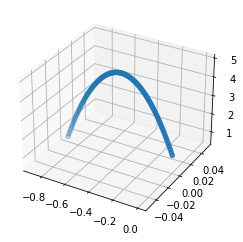

In [21]:
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

###inputs
p1=np.array([0, 0, 1.3])#first point
shelf_pos = get_shelf_pos()
# final_target = shelf_pos + np.array([0, 0, height])
final_target[0] += get_anchor_dist()
p2=final_target #second point
npts = 100 # number of points to sample
y=np.array([0,.5,.75,.75,.5,0]) #describe your shape in 1d like this
amp=5 #curve height factor. bigger means heigher 

#get the adder. This will be used to raise the z coords
x=np.arange(y.size)
xnew = np.linspace(x[0],x[-1] , npts) #sample the x coord
tck = interpolate.splrep(x,y,s=0) 
adder = interpolate.splev(xnew,tck,der=0)*amp
adder[0]=adder[-1]=0
adder=adder.reshape((-1,1))

#get a line between points
arc=np.vstack([np.linspace(p1[dim],p2[dim],npts) for dim in range(3)]).T

#raise the z coordinate
arc[:,-1]=arc[:,-1]+adder[:,-1]

print(arc[:,2].shape)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(arc[:,0], arc[:,1], arc[:,2])
plt.show()

og shelf pos [-1.5, 0.0, 0.3]
shelf_width 0.3
Iterators : 1
WorkingTime[inverse_kinematics]: 0.0122 sec

Iterators : 63
WorkingTime[inverse_kinematics]: 0.1120 sec

Iterators : 132
WorkingTime[inverse_kinematics]: 0.1782 sec

Iterators : 175
WorkingTime[inverse_kinematics]: 0.2286 sec

Iterators : 200
WorkingTime[inverse_kinematics]: 0.2937 sec

Iterators : 229
WorkingTime[inverse_kinematics]: 0.3016 sec

Iterators : 246
WorkingTime[inverse_kinematics]: 0.3271 sec

Iterators : 254
WorkingTime[inverse_kinematics]: 0.3356 sec

Iterators : 262
WorkingTime[inverse_kinematics]: 0.3445 sec

Iterators : 259
WorkingTime[inverse_kinematics]: 0.3390 sec

Iterators : 249
WorkingTime[inverse_kinematics]: 0.3208 sec

Iterators : 225
WorkingTime[inverse_kinematics]: 0.2941 sec

Iterators : 179
WorkingTime[inverse_kinematics]: 0.2353 sec

Iterators : 212
WorkingTime[inverse_kinematics]: 0.2776 sec

Iterators : 232
WorkingTime[inverse_kinematics]: 0.3052 sec

Iterators : 219
WorkingTime[inverse_kinema

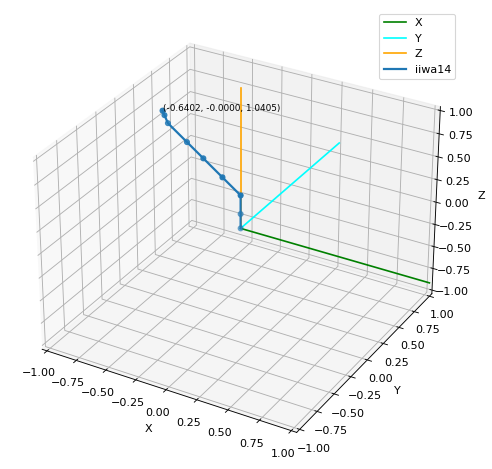

In [22]:
pykin_path = './pykin/pykin'
sys.path.append(pykin_path)
from pykin.robots.single_arm import SingleArm
from pykin.kinematics import transform as tf
from pykin.utils import plot_utils as pykin_plt

urdf_path = f'{pykin_path}/../asset/urdf/iiwa14/iiwa14.urdf'

robot = SingleArm(urdf_path, tf.Transform(rot=[0.0, 0.0, 0.0], pos=[0, 0, 0]))

# iiwa14 example
init_thetas = np.zeros(7)

robot.setup_link_name("iiwa14_link_0", "iiwa14_right_hand")
# target_pose #(7,), [:3] target pos, [3:] quaternion
shelf_pos = get_shelf_pos()
# print('shelf_pos', shelf_pos)
# target = shelf_pos + np.array([0, 0, height])
# target[0] += get_anchor_dist()
# target[0] = 0
# target = np.array([0, 0, 1])
joints_lst = [init_thetas]

for target in arc[::5]:
    joints = robot.inverse_kin(joints_lst[-1], target, method="LM")
    joints_lst.append(joints)

joints = robot.inverse_kin(joints_lst[-2], target, method="LM")
result_fk = robot.forward_kin(joints)

_, ax = pykin_plt.init_3d_figure("IK")
pykin_plt.plot_robot(
    robot, 
    ax=ax,
    transformations=result_fk)
pykin_plt.show_figure()

In [23]:
# intermediate_pose = joints

obs = env.reset()
for intermediate_pose in joints_lst:
    done = False
    timesteps = 30
    for i in range(timesteps):
        jpos = np.array([env.sim.data.get_joint_qpos("robot0_joint_" + str(joint)) for joint in range(1, 8)])
        obs, reward, done, info = env.step(50 * (intermediate_pose - jpos))
        if i == timesteps - 1:
            last_pos = env.sim.data.geom_xpos[env.sim.model.geom_name2id("gripper0_anchor")]
        env.render()
print(last_pos)

Creating window glfw
[-1.19911055e+00 -4.15118208e-06  1.28064743e+00]


In [80]:
import numpy as np
from gym import spaces
from gym.core import Env
from robosuite.wrappers import Wrapper


class GymWrapper(Wrapper, Env):
    def __init__(self, env, keys=None):
        # Run super method
        super().__init__(env=env)
        # Create name for gym
        robots = "".join([type(robot.robot_model).__name__ for robot in self.env.robots])
        self.name = robots + "_" + type(self.env).__name__

        # Get reward range
        self.reward_range = (0, self.env.reward_scale)

        # Gym specific attributes
        self.env.spec = None
        self.metadata = None

        # set up observation and action spaces

    def reset(self):
        self.env.reset()
        jpos = [self.env.sim.data.get_joint_qpos("robot0_joint_" + str(joint)) for joint in range(1, 8)]
        gpos = []
        for j in range(1, num_cloth_joints + 1):
            pos = self.env.sim.data.geom_xpos[self.env.sim.model.geom_name2id("gripper0_geom{}".format(j))]
            gpos.append(pos[0])
            gpos.append(pos[2])
        return np.array(jpos + gpos)

    def step(self, action):
        ob_dict, reward, done, info = self.env.step(action)
        jpos = [self.env.sim.data.get_joint_qpos("robot0_joint_" + str(joint)) for joint in range(1, 8)]
        gpos = []
        for j in range(1, num_cloth_joints + 1):
            pos = self.env.sim.data.geom_xpos[self.env.sim.model.geom_name2id("gripper0_geom{}".format(j))]
            gpos.append(pos[0])
            gpos.append(pos[2])
        return np.array(jpos + gpos), reward, done, info

In [81]:
from stable_baselines3.common.vec_env import SubprocVecEnv

multi_env = SubprocVecEnv([lambda: GymWrapper(suite.make(
    "Empty",
    robots="IIWA",             # load a Sawyer robot and a Panda robot
    gripper_types="ClothGripper",                # use default grippers per robot arm
    controller_configs=controller_config, 
    has_offscreen_renderer=False,           # no off-screen rendering
    render_collision_mesh=False,
    control_freq=20,                        # 20 hz control for applied actions
    horizon=horizon,                            # each episode terminates after 200 steps
    use_object_obs=False,                   # no observations needed
    use_camera_obs=False,                   # no observations needed
)) for _ in range(6)])

ModuleNotFoundError: No module named 'stable_baselines3'

In [8]:
def simulate(actions):
    obs = multi_env.reset()
    for i in range(90):
        obs, reward, done, info = multi_env.step(50 * (intermediate_pose - obs[:, :-num_cloth_joints * 2]))
    done = False
    for action in actions:
        obs, reward, done, info = multi_env.step([action] * 10)
#         env.render()
    return np.mean(obs[:, -num_cloth_joints * 2:], axis=0).tolist()

In [9]:
simulate([0] * 7 for _ in range(100))

[-1.527199959553757,
 0.7474461882366104,
 -1.5472393198068766,
 0.7431249860471301,
 -1.5672732326513101,
 0.7387785985223078,
 -1.5873030350384794,
 0.7344133075584022,
 -1.6073298906463414,
 0.7300345173506071,
 -1.6273547767836505,
 0.725646729223822,
 -1.6473784793437372,
 0.7212535429786869,
 -1.6674015895252072,
 0.7168576575922465,
 -1.6874244997650063,
 0.7124608615743666]

In [10]:
# Creating window glfw
# 0.3947247381978785 1.4747500155867088
# 0.4325377648709574 1.4618376387611147
# 0.4628294377820218 1.4357794320709718
# 0.48462112128783885 1.4022774211105264
# 0.5000900615573327 1.3654188162897296
# 0.5112945770153463 1.327043015878611
# 0.5197121021754062 1.2879579491907713
# 0.5263528085181368 1.248530098043205
# 0.5318898955244334 1.208930975736482
# 0.5367795093650977 1.1692460094641723
# 0.5413225304158094 1.1295195069109842
# 0.5457894399151935 1.0897842940255975

In [11]:
import itertools

goal_state_x = [-1.4 - 0.04 * i for i in range(num_cloth_joints)]
goal_state_y = [0.6 for i in range(num_cloth_joints)]
goal_state = list(itertools.chain(*zip(goal_state_x, goal_state_y)))
print(goal_state)

def goal_dist(positions):
    return np.sqrt(np.sum(np.square(np.array(positions) - np.array(goal_state))))

def in_goal(positions):
    for i in range(0, len(positions), 2):
        if not (positions[i] <= -1.4):
            return False
        if not (0.6 <= positions[i + 1] <= 0.7):
            return False
    return True
# goal_dist(simulate([[0, 0.8, 0, -0.5, 0, -0.1, 0] for _ in range(200)]))

[-1.4, 0.6, -1.44, 0.6, -1.48, 0.6, -1.52, 0.6, -1.5599999999999998, 0.6, -1.5999999999999999, 0.6, -1.64, 0.6, -1.68, 0.6, -1.72, 0.6]


In [12]:
import collections
import heapq

class PriorityQueue:
    def __init__(self):
        self.elements = []

    def empty(self):
        return len(self.elements) == 0

    def put(self, item, priority):
        heapq.heappush(self.elements, (priority, item))

    def get(self):
        return heapq.heappop(self.elements)[1]

In [13]:
def generate_possible_actions(num_joints):
    possible_actions = []
    def genbin(n, bs=[]):
        if len(bs) == n:
            possible_actions.append(bs)
        else:
            genbin(n, bs + [0.4])
            genbin(n, bs + [-0.4])


    genbin(num_joints)
    return possible_actions

all_possible_actions = generate_possible_actions(7)
print(all_possible_actions)

[[0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4], [0.4, 0.4, 0.4, 0.4, 0.4, 0.4, -0.4], [0.4, 0.4, 0.4, 0.4, 0.4, -0.4, 0.4], [0.4, 0.4, 0.4, 0.4, 0.4, -0.4, -0.4], [0.4, 0.4, 0.4, 0.4, -0.4, 0.4, 0.4], [0.4, 0.4, 0.4, 0.4, -0.4, 0.4, -0.4], [0.4, 0.4, 0.4, 0.4, -0.4, -0.4, 0.4], [0.4, 0.4, 0.4, 0.4, -0.4, -0.4, -0.4], [0.4, 0.4, 0.4, -0.4, 0.4, 0.4, 0.4], [0.4, 0.4, 0.4, -0.4, 0.4, 0.4, -0.4], [0.4, 0.4, 0.4, -0.4, 0.4, -0.4, 0.4], [0.4, 0.4, 0.4, -0.4, 0.4, -0.4, -0.4], [0.4, 0.4, 0.4, -0.4, -0.4, 0.4, 0.4], [0.4, 0.4, 0.4, -0.4, -0.4, 0.4, -0.4], [0.4, 0.4, 0.4, -0.4, -0.4, -0.4, 0.4], [0.4, 0.4, 0.4, -0.4, -0.4, -0.4, -0.4], [0.4, 0.4, -0.4, 0.4, 0.4, 0.4, 0.4], [0.4, 0.4, -0.4, 0.4, 0.4, 0.4, -0.4], [0.4, 0.4, -0.4, 0.4, 0.4, -0.4, 0.4], [0.4, 0.4, -0.4, 0.4, 0.4, -0.4, -0.4], [0.4, 0.4, -0.4, 0.4, -0.4, 0.4, 0.4], [0.4, 0.4, -0.4, 0.4, -0.4, 0.4, -0.4], [0.4, 0.4, -0.4, 0.4, -0.4, -0.4, 0.4], [0.4, 0.4, -0.4, 0.4, -0.4, -0.4, -0.4], [0.4, 0.4, -0.4, -0.4, 0.4, 0.4, 0.4], [0.4, 0.4, -0.4, -0.

In [14]:
start_position = simulate([0] * 7 for _ in range(100))

def neighbors(positions, actions):
    possible_actions = np.array(all_possible_actions)
    
    for action in possible_actions:
        result = simulate(actions + [action])
        yield result, actions + [action]

def discretize(positions, size=0.0002):
    def round_nearest(x, size):
        return round(x / size) * size
    return tuple([round_nearest(x, size) for x in positions])

In [15]:
queue = PriorityQueue()
queue.put(discretize(start_position), 0)
actions_so_far = {discretize(start_position): []}
cost_so_far = {discretize(start_position): 0}

while not queue.empty():
    curr_pose = queue.get()

    if in_goal(curr_pose):
        print("done", curr_pose)
        break

    for next_pose, actions in neighbors(curr_pose, actions_so_far[curr_pose]):
        next_pose = discretize(next_pose)
        new_cost = cost_so_far[curr_pose] + 0.001
        if next_pose not in cost_so_far or new_cost < cost_so_far[next_pose]:
            cost_so_far[next_pose] = new_cost
            actions_so_far[next_pose] = actions
            priority = new_cost + goal_dist(next_pose)
            queue.put(next_pose, priority)
            print(goal_dist(next_pose), actions)


0.4461880769361731 [array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])]
0.4477126757195961 [array([ 0.4,  0.4,  0.4,  0.4,  0.4,  0.4, -0.4])]
0.44289646645689135 [array([ 0.4,  0.4,  0.4,  0.4,  0.4, -0.4,  0.4])]
0.44457354847089164 [array([ 0.4,  0.4,  0.4,  0.4,  0.4, -0.4, -0.4])]
0.44658531099891796 [array([ 0.4,  0.4,  0.4,  0.4, -0.4,  0.4,  0.4])]
0.4480115623507949 [array([ 0.4,  0.4,  0.4,  0.4, -0.4,  0.4, -0.4])]
0.44512658873628325 [array([ 0.4,  0.4,  0.4,  0.4, -0.4, -0.4,  0.4])]
0.44155189955428825 [array([ 0.4,  0.4,  0.4,  0.4, -0.4, -0.4, -0.4])]
0.4524900440893702 [array([ 0.4,  0.4,  0.4, -0.4,  0.4,  0.4,  0.4])]
0.45138356195147405 [array([ 0.4,  0.4,  0.4, -0.4,  0.4,  0.4, -0.4])]
0.4471748651254901 [array([ 0.4,  0.4,  0.4, -0.4,  0.4, -0.4,  0.4])]
0.4479527653670644 [array([ 0.4,  0.4,  0.4, -0.4,  0.4, -0.4, -0.4])]
0.4512265949608913 [array([ 0.4,  0.4,  0.4, -0.4, -0.4,  0.4,  0.4])]
0.4521420573226961 [array([ 0.4,  0.4,  0.4, -0.4, -0.4,  0.4, -0.4])]
0.44724

0.4356488494188872 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4,  0.4,  0.4,  0.4, -0.4])]
0.4327477787349119 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4,  0.4,  0.4, -0.4,  0.4])]
0.43372613479014643 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4,  0.4,  0.4, -0.4, -0.4])]
0.43602403603471257 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4,  0.4, -0.4,  0.4,  0.4])]
0.4338827952339205 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4,  0.4, -0.4,  0.4, -0.4])]
0.43184812145012313 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4,  0.4, -0.4, -0.4,  0.4])]
0.43242349612388115 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4,  0.4, -0.4, -0.4, -0.4])]
0.44017405648220603 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4, -0.4,  0.4,  0.4,  0.4])]
0.438896798803546 [

0.4389489719773818 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4, -0.4,  0.4,  0.4,  0.4])]
0.43746501574411667 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4, -0.4,  0.4,  0.4, -0.4])]
0.4370509810079372 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4, -0.4,  0.4, -0.4, -0.4])]
0.43757929567108206 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4, -0.4, -0.4,  0.4,  0.4])]
0.4376311689082489 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4, -0.4, -0.4,  0.4, -0.4])]
0.4377581524083821 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4, -0.4, -0.4, -0.4,  0.4])]
0.4367943223074223 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4, -0.4, -0.4, -0.4, -0.4])]
0.4341086039230279 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4,  0.4, -0.4,  0.4,  0.4,  0.4,  0.4])]
0.4336361608537741 [ar

0.41879001898326107 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,  0.4, -0.4,  0.4, -0.4, -0.4,  0.4])]
0.4167177462023909 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,  0.4, -0.4,  0.4, -0.4, -0.4, -0.4])]
0.425031387076296 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,  0.4, -0.4, -0.4,  0.4,  0.4,  0.4])]
0.42348246716953963 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,  0.4, -0.4, -0.4,  0.4,  0.4, -0.4])]
0.4216243351610533 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,  0.4, -0.4, -0.4,  0.4, -0.4,  0.4])]
0.4204294471133061 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,

0.4204525181277908 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4,  0.4, -0.4, -0.4, -0.4,  0.4])]
0.42227450787372917 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4,  0.4, -0.4, -0.4, -0.4, -0.4])]
0.42055591780404206 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4, -0.4,  0.4,  0.4,  0.4, -0.4])]
0.417422950974189 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4, -0.4,  0.4,  0.4, -0.4,  0.4])]
0.4165938069630899 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4, -0.4,  0.4,  0.4, -0.4, -0.4])]
0.4201752491520654 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,

0.401571114499039 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,  0.4,  0.4,  0.4,  0.4, -0.4, -0.4])]
0.4051262025591535 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,  0.4,  0.4,  0.4, -0.4,  0.4,  0.4])]
0.4038267945542993 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,  0.4,  0.4,  0.4, -0.4,  0.4, -0.4])]
0.4012634047605142 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,  0.4,  0.4,  0.4, -0.4, -0.4,  0.4])]
0.401297096924461 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4

0.401066129210633 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4, -0.4,  0.4, -0.4, -0.4])]
0.4024753408595367 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4, -0.4, -0.4,  0.4,  0.4])]
0.4025115153632256 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4, -0.4, -0.4,  0.4, -0.4])]
0.4006424840178587 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4, -0.4, -0.4, -0.4,  0.4])]
0.40163714967617253 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0

0.3985486168587218 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4, -0.4,  0.4, -0.4, -0.4, -0.4])]
0.4064309535456179 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4, -0.4, -0.4,  0.4,  0.4,  0.4])]
0.40525088525504815 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4, -0.4, -0.4,  0.4,  0.4, -0.4])]
0.4045694995918504 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4, -0.4, -0.4,  0.4, -0.4,  0.4])]
0.40549115896650606 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, 

0.40229432011898975 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4])]
0.3856019190823618 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])]
0.38525134652587567 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4,  0.4,  0.4,  0.4, -0.4])]
0.38578164808606463 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array(

0.3810095536859939 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4,  0.4,  0.4])]
0.38353122428297837 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4,  0.4, -0.4])]
0.38183425723735187 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4,  0.4])]
0.38073292476485443 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]),

0.3869429415301437 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4,  0.4,  0.4,  0.4,  0.4])]
0.3861067727973704 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4,  0.4,  0.4,  0.4, -0.4])]
0.3850068051346629 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4,  0.4,  0.4, -0.4,  0.4])]
0.38477323191719076 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), a

0.3825437491320439 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4,  0.4,  0.4, -0.4,  0.4, -0.4])]
0.37941138622872167 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4])]
0.3811513085376991 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4,  0.4,  0.4, -0.4, -0.4, -0.4])]
0.3858463424732705 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), a

0.36900791319428394 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4,  0.4, -0.4, -0.4,  0.4])]
0.3698990132455076 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4,  0.4, -0.4, -0.4, -0.4])]
0.3753698442869382 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4, -0.4,  0.4,  0.4,  0.4])]
0.37459610248906783 [

0.36619284536975905 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4,  0.4])]
0.36241749405899304 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4])]
0.3661465280458087 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4,  0.4,  0.4])]
0.3665736488074398 [

0.36768633371394194 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4, -0.4, -0.4, -0.4,  0.4])]
0.3665820508426459 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4])]
0.3690636259508653 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4,  0.4,  0.4, -0.4,  0.4])]
0.36942522924131777 [

0.37548533926106914 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4, -0.4, -0.4, -0.4,  0.4,  0.4])]
0.37419748796591384 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4, -0.4, -0.4, -0.4,  0.4, -0.4])]
0.37181640630827495 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4, -0.4, -0.4, -0.4, -0.4,  0.4])]
0.3669942778845472 

0.3684401715339958 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4, -0.4, -0.4, -0.4,  0.4])]
0.3558925680595202 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([0.4, 0.4, 0.4, 0.4, 0.4, 0.4, 0.4])]
0.3583459780714725 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4

0.35468724251092004 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4,  0.4, -0.4,  0.4, -0.4,  0.4, -0.4])]
0.3528468222897866 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4,  0.4, -0.4,  0.4, -0.4, -0.4,  0.4])]
0.35397180678692514 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -

0.35436907314267735 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4, -0.4, -0.4,  0.4, -0.4])]
0.35317632989768755 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4, -0.4, -0.4, -0.4,  0.4])]
0.3528977755668066 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -

0.35488691156479735 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4,  0.4, -0.4,  0.4,  0.4])]
0.35517713890395625 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4,  0.4, -0.4,  0.4, -0.4])]
0.3545694854326868 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -

0.35779016196648034 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4, -0.4, -0.4,  0.4, -0.4, -0.4])]
0.3598883160092867 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4, -0.4, -0.4, -0.4,  0.4,  0.4])]
0.3590106962194863 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0

0.3513476341175506 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4,  0.4, -0.4])]
0.3483370207141357 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4])]
0.34951904096915837 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0

0.34301148668812853 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4, -0.4, -0.4,  0.4, -0.4])]
0.34068049547926893 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4,  0.4,  0.4, -0.4, -0.4, -0.4,  0.4])]
0.3407303332549073 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  

0.3356992106037788 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4,  0.4, -0.4])]
0.33526079400967873 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4,  0.4])]
0.3342071214082672 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0

0.3334281331861489 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4])]
0.3346216370768636 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4])]
0.33989233589476575 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0

0.34000882341492283 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4, -0.4,  0.4, -0.4,  0.4])]
0.3426199060183168 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4,  0.4,  0.4, -0.4,  0.4, -0.4, -0.4])]
0.34340896901508 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4

0.3372735388375439 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4,  0.4,  0.4,  0.4,  0.4, -0.4])]
0.33597618963253956 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4,  0.4,  0.4,  0.4, -0.4,  0.4])]
0.3346099819192492 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0

0.33640273482836053 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4,  0.4, -0.4])]
0.33115603572938274 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4])]
0.33566691823889977 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4, 

0.3294718197357707 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,  0.4,  0.4, -0.4,  0.4,  0.4, -0.4])]
0.32800762186266375 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,  0.4,  0.4, -0.4,  0.4, -0.4,  0.4])]
0.32674314070841676 [array([ 0.4, -0.4, -

0.32630954629002235 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4,  0.4, -0.4, -0.4, -0.4, -0.4, -0.4])]
0.32310995032651074 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4,  0.4,  0.4])]
0.3227839525131326 [array([ 0.4, -0.4, -

0.3228410135035513 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4,  0.4, -0.4])]
0.32114682000605305 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4,  0.4])]
0.32114277198778773 [array([ 0.4, -0.4, -

0.3251169635684983 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4,  0.4,  0.4, -0.4,  0.4,  0.4])]
0.3270805405400942 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4,  0.4,  0.4, -0.4,  0.4, -0.4])]
0.323028729372482 [array([ 0.4, -0.4, -0.4

0.32581786323036405 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4, -0.4, -0.4,  0.4, -0.4,  0.4])]
0.32592048109930166 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4,  0.4, -0.4, -0.4,  0.4, -0.4, -0.4])]
0.328621727826996 [array([ 0.4, -0.4, -0

0.3222677768564524 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4, -0.4,  0.4, -0.4, -0.4,  0.4, -0.4])]
0.32277688888766526 [array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4, -0.4,  0.4, -0.4, -0.4, -0.4,  0.4])]
0.3224695334446344 [array([ 0.4, -0.4, -0

In [23]:
found_actions = "[array([ 0.4, -0.4, -0.4,  0.4, -0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4, -0.4, -0.4,  0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4,  0.4,  0.4,  0.4, -0.4, -0.4]), array([ 0.4, -0.4, -0.4,  0.4,  0.4, -0.4, -0.4]), array([-0.4, -0.4, -0.4,  0.4, -0.4, -0.4,  0.4]), array([-0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4])]"

In [24]:
# def change_shelf_height():
#     # TODO: make random values instead of fixed
#     springdamper_time_constant = random.expovariate(1/0.001)
#     springdamper_damping_ratio = random.uniform(0, 10)
#     frictionloss = random.uniform(0, 10)
#     tendon_stiffness = random.uniform(0, 1)
#     tendon_damping = random.uniform(0, 10)
#     tendon_frictionloss = random.uniform(0, 10)
    
#     # TODO: convert to string
#     springdamper_str = str(springdamper_time_constant) + ' ' + str(springdamper_damping_ratio)
#     frictionloss_str = str(frictionloss)
#     tendon_stiffness_str = str(tendon_stiffness)
#     tendon_damping_str = str(tendon_damping)
#     tendon_frictionloss_str = str(tendon_frictionloss)
    
#     tree = ET.parse('./robosuite/robosuite/models/assets/arenas/empty_arena.xml')
#     root = tree.getroot()
# #     print('THIS IS ROOT: ', root)
    
#     shelf = root.find('worldbody').find('body').find('geom')
#     height = 

#     shelf.set('size', '0.3 0.5 ' + str(height))
    
#     tree.write('./robosuite/robosuite/models/assets/arenas/empty_arena.xml')

In [25]:
def simulate_render(actions):
    all_geom_positions = []
    for _ in range(10):
        obs = env.reset()
        done = False
        for action in actions:
            obs, reward, done, info = env.step(action)
            env.render()
        geom_positions = []
        for j in range(1, num_cloth_joints + 1):
            pos = env.sim.data.geom_xpos[env.sim.model.geom_name2id("gripper0_geom{}".format(j))]
            geom_positions.append(pos[0])
            geom_positions.append(pos[2])
        all_geom_positions.append(geom_positions)
    return np.mean(np.array(all_geom_positions), axis=0).tolist()

env = suite.make(
    "Empty",
    robots="IIWA",             # load a Sawyer robot and a Panda robot
    gripper_types="ClothGripper",                # use default grippers per robot arm
    controller_configs=controller_config, 
    has_renderer=True,                      # on-screen rendering
    render_camera="sideview",              # visualize the "frontview" camera
    has_offscreen_renderer=False,           # no off-screen rendering
    render_collision_mesh=True,
    control_freq=20,                        # 20 hz control for applied actions
    horizon=horizon,                            # each episode terminates after 200 steps
    use_object_obs=False,                   # no observations needed
    use_camera_obs=False,                   # no observations needed
)

found_actions = eval(found_actions.replace("array", "").replace("(", "").replace(")", ""))
print(found_actions)
simulate_render(found_actions)

Creating window glfw
[[0.4, -0.4, -0.4, 0.4, -0.4, -0.4, -0.4], [-0.4, -0.4, -0.4, 0.4, -0.4, -0.4, 0.4], [0.4, -0.4, 0.4, 0.4, -0.4, -0.4, 0.4], [0.4, -0.4, 0.4, 0.4, 0.4, -0.4, -0.4], [-0.4, -0.4, -0.4, 0.4, 0.4, -0.4, -0.4], [0.4, -0.4, 0.4, 0.4, 0.4, -0.4, -0.4], [0.4, -0.4, -0.4, 0.4, 0.4, -0.4, -0.4], [-0.4, -0.4, -0.4, 0.4, -0.4, -0.4, 0.4], [-0.4, -0.4, -0.4, -0.4, -0.4, -0.4, -0.4]]
Creating window glfw
Creating window glfw
Creating window glfw
Creating window glfw
Creating window glfw
Creating window glfw
Creating window glfw
Creating window glfw
Creating window glfw
Creating window glfw


[-1.1193367303230946,
 1.1955712304461463,
 -1.138900091423044,
 1.2016716792359898,
 -1.1584713352679725,
 1.2077467417649184,
 -1.1780484530526834,
 1.2138028113396238,
 -1.1976297561696034,
 1.219845307959535,
 -1.2172138203320937,
 1.225878832211127,
 -1.236799536039952,
 1.231906982580806,
 -1.2563860741836428,
 1.2379324549330912,
 -1.2759728871427813,
 1.2439570321143871]